# 📒 MobilePlantViT - AI Crop Disease Detector

## 0. Environment Setup & Library Imports
---

In [2]:
# Install optional libraries (if needed in Colab)
%pip install -q -U keras-tuner
%pip install -q -U tensorboard-plugin-profile
%pip install -q streamlit

# Reproducibility & Imports
import os, math, json, random, tensorflow as tf
import keras_tuner as kt
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import datetime

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enable mixed precision (for faster training on Colab GPUs)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

AUTOTUNE = tf.data.AUTOTUNE

# Utils
def get_run_logdir(root):
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(root, exist_ok=True)
    return os.path.join(root, stamp)

def cardinality(ds):
    """Best effort steps/epoch for schedules & callbacks."""
    c = tf.data.experimental.cardinality(ds).numpy()
    return None if c < 0 else int(c)

print("TF version:", tf.__version__)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
TF version: 2.18.0


## 1. Introduction 🌱
---

Agriculture remains the backbone of rural economies—especially in the Global South—where it employs over **65% of the workforce** in some developing regions (source: digitalplanet.tufts.edu). Yet, farmers continue to face **unpredictable losses due to pests, disease, and climate volatility**. These challenges contribute to a staggering level of food insecurity, affecting an estimated **2.3 billion people globally** (source: publicpolicy.google).

To address this, **deep learning–based diagnostic tools** offer a scalable, data-driven solution. One real-world success story is **Wadhwani AI’s pest detection app** in India, which increased farmer profits by **20%** and reduced pesticide use by **25%** by enabling timely and precise interventions (source: publicpolicy.google). This dual impact—**improved incomes and environmental benefits**—underscores the power of AI in agriculture.

In **Latin America**, the potential is equally transformative:
- A **4-year study in Colombia** showed that ML-guided recommendations based on weather and soil data boosted maize yields from **3.5 to over 6 tons per hectare**—a **~70% increase** (source: eurekalert.org).
- In Chile’s **Biobío region**, AI-powered irrigation systems led to **30% less water use** and **20% higher yields**, demonstrating efficiency gains through resource-aware agriculture (source: developmentaid.org).
- AI-guided precision spraying systems such as **AgZen**, an MIT spinoff, have reduced pesticide volumes by **30–50%** while also **increasing crop yields** via precise targeting and real-time feedback (source: news.mit.edu).

These results show that **AI-based agriculture can deliver double-digit improvements** in both yield and cost efficiency—outcomes that directly support **food security, farmer livelihoods, and environmental sustainability**.

**Project Goal:** This project presents **MobilePlantViT**, a deep learning solution designed for smallholder farmers in Latin America. It uses lightweight CNN or ViT architectures to detect plant diseases from **smartphone images**, enabling **real-time, offline diagnostics** even in low-connectivity environments.

By combining accurate classification with edge deployment, this tool could:
- Prevent crop losses from disease.
- Increase productivity by reducing treatment delay.
- Minimize overuse of agrochemicals.
- Empower millions of farmers with actionable AI.

Ultimately, this system could help unlock significant **yield and income gains**, while reducing the environmental footprint of farming.

## 2. Project Objectives 🎯
---

- Use transfer learning on the PlantVillage dataset.
- Train a lightweight CNN model optimized for mobile inference.
- Export to TensorFlow Lite for offline deployment.
- Evaluate accuracy, latency, and confusion metrics.
- Provide a working demo via Streamlit or mobile.

## 3. Dataset Loading & Preprocessing
---

This section handles loading the PlantVillage dataset and preparing it for training:

- Splits the dataset into 70% training, 15% validation, and 15% test.
- Enables mixed precision training for speed and efficiency on supported GPUs.
- Resizes images and applies MobileNetV3 preprocessing.
- Uses TensorFlow tf.data pipeline for efficient loading (caching, batching, prefetching).

In [ ]:
# Load dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 160
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
NUM_CLASSES = ds_info.features['label'].num_classes

# Preprocess function
def format_image(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.keras.applications.mobilenet_v3.preprocess_input(tf.cast(image, tf.float32))
  return image, label

# Apply mapping, caching, batching, prefetching
def prepare(ds):
  return (ds
          .map(format_image, num_parallel_calls=AUTO)
          .shuffle(1000)
          .batch(BATCH_SIZE)
          .prefetch(AUTO))

ds_train = prepare(ds_train)
ds_val = prepare(ds_val)
ds_test = prepare(ds_test)

STEPS_PER_EPOCH = cardinality(ds_train)
VAL_STEPS = cardinality(ds_val)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## 4. Dataset Visualization & Class Balance
---

- Display sample images per disease category to validate labels and variability.

- Plot class distributions to check for imbalance.

- Visualize augmented samples to illustrate variability introduced.

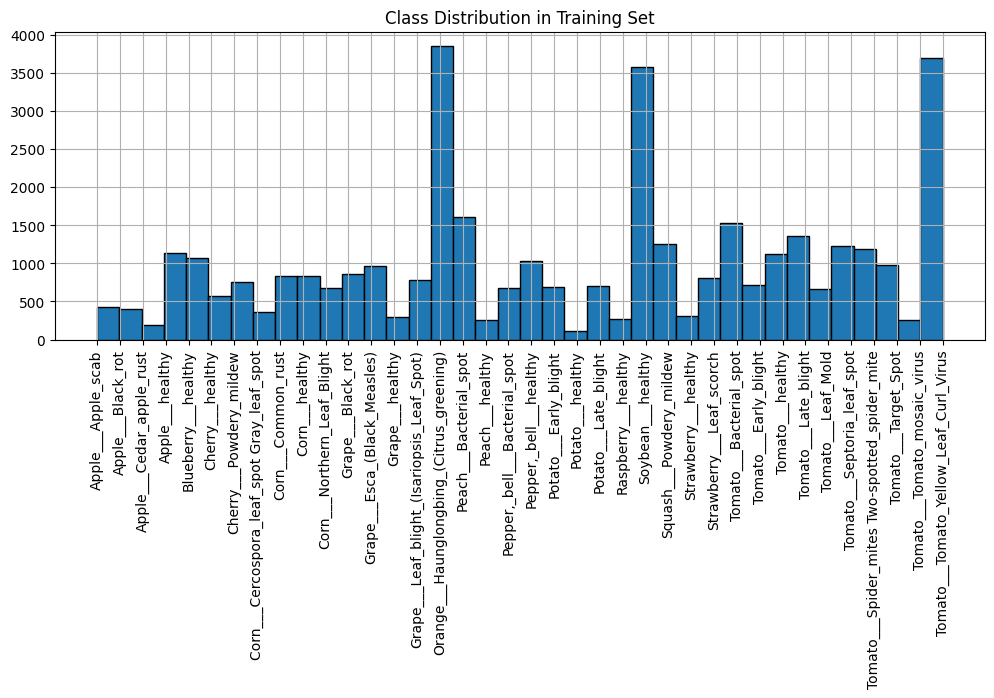

In [4]:
class_names = ds_info.features['label'].names

# Class distribution histogram
labels = []
for _, label in tfds.as_numpy(ds_train.unbatch()):
  labels.append(label)

plt.figure(figsize=(12, 4))
plt.hist(labels, bins=len(class_names), edgecolor='k')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.title("Class Distribution in Training Set")
plt.grid(True)
plt.show()

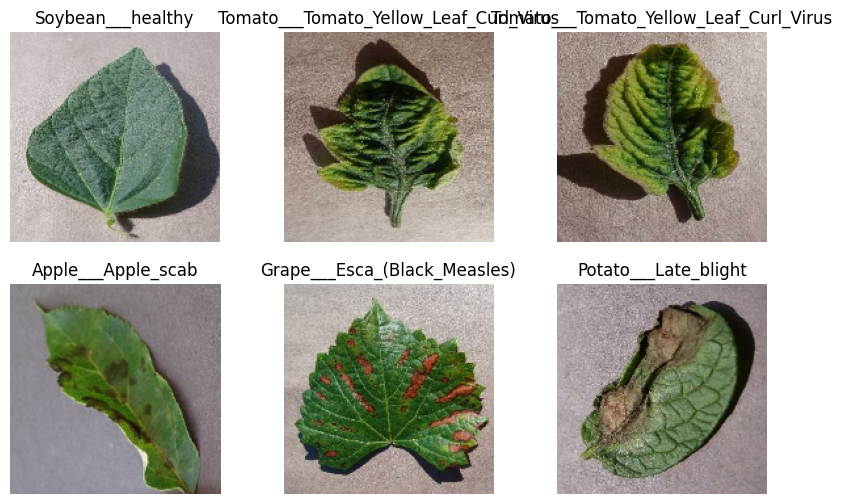

In [5]:
# Sample images
def format_image_for_visualization(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

ds_plot = ds_train.map(format_image_for_visualization)

plt.figure(figsize=(10, 6))
for images, labels in ds_plot.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 5. Model Architecture (MobileNetV3Small)
---

Defines the CNN-based model architecture using MobileNetV3Small:

- Loads a pretrained MobileNetV3Small model with ImageNet weights as a frozen base (transfer learning).
- Applies data augmentation using TensorFlow's built-in layers to improve robustness.
- Adds a global average pooling, a dropout layer to prevent overfitting, and dense layers for classification.
- Uses softmax output with float32 precision for compatibility with mixed precision training.

This architecture is efficient and optimized for mobile deployment (TFLite-compatible).

In [6]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___Powdery_mildew',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___healthy',
 'Corn___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomat

In [7]:
# Reusable data augmentation layer
def make_augmentation_layer(use_aug=True):
  if not use_aug:
      return tf.keras.Sequential([tf.keras.layers.Activation('linear')], name="no_aug")
  return tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.15, 0.15),
      tf.keras.layers.RandomContrast(0.15),
  ], name="aug")

In [8]:
# LR schedules (warmup + cosine)
from keras.saving import register_keras_serializable

@register_keras_serializable(package="lr_schedules")   # <-- registers the name
class WarmupCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, min_lr, warmup_steps, total_steps):
        super().__init__()
        self.base_lr = float(base_lr)
        self.min_lr = float(min_lr)
        self.warmup_steps = int(warmup_steps)
        self.total_steps = int(max(self.warmup_steps + 1, int(total_steps)))

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warm_lr = self.base_lr * (step + 1.0) / float(self.warmup_steps)
        progress = tf.clip_by_value(
            (step - self.warmup_steps) / tf.maximum(1.0, (self.total_steps - self.warmup_steps)), 0.0, 1.0
        )
        pi_const = tf.constant(math.pi, dtype=tf.float32)
        cosine = 0.5 * (1.0 + tf.cos(pi_const * progress))
        decayed = self.min_lr + (self.base_lr - self.min_lr) * cosine
        return tf.where(step < self.warmup_steps, warm_lr, decayed)

    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "min_lr": self.min_lr,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [9]:
# Model factory used by the tuner (and standalone)
def build_finetune_model(hp, steps_per_epoch=None, epochs=10, phase="head"):
  """
  phase: "head" for head-only training, "ft" for fine-tuning
  """
  # Hyperparameters
  use_aug = hp.Boolean("use_data_augmentation", default=True)
  trainable_base = hp.Boolean("trainable_base_model", default=False)
  dense_units = hp.Int("dense_units", 128, 256, step=64, default=128)
  dropout_rate = hp.Float("dropout", 0.1, 0.3, step=0.1, default=0.2)
  activation_choice = hp.Choice("activation", ["relu", "swish"], default="relu")

  # Optimizer & schedule
  base_lr = hp.Choice("learning_rate", [1e-3, 3e-4, 1e-4], default=3e-4)
  weight_decay = hp.Float("weight_decay", 1e-5, 5e-5, sampling="log", default=5e-5)

  # How deep to unfreeze when trainable_base=True (used in phase "ft")
  unfreeze_last_n = hp.Int("unfreeze_last_n_layers", 30, 90, step=15, default=60)

  # ---------- Base & augmentation ----------
  base_model = tf.keras.applications.MobileNetV3Small(
      input_shape=(IMG_SIZE, IMG_SIZE, 3),
      include_top=False,
      weights="imagenet"
  )
  base_model.trainable = trainable_base if phase == "ft" else False

  if base_model.trainable and phase == "ft":
      # Freeze all, then unfreeze last N layers for stability
      for layer in base_model.layers:
          layer.trainable = False
      for layer in base_model.layers[-unfreeze_last_n:]:
          layer.trainable = True

  aug = make_augmentation_layer(use_aug=use_aug)

  # Head: GAP -> Dropout -> Dense(no bias) -> BN -> Activation
  inp = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = aug(inp)
  x = base_model(x, training=False)  # keep BN stats stable in head phase
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)

  # kernel init matched to activation
  kernel_init = "he_normal" if activation_choice == "relu" else "glorot_uniform"
  x = tf.keras.layers.Dense(
    dense_units, use_bias=False,
    kernel_initializer=kernel_init,
    kernel_regularizer=tf.keras.regularizers.L2(weight_decay),
    dtype="float32"  # keep head math in fp32
  )(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(
    tf.keras.activations.relu if activation_choice == "relu" else tf.keras.activations.swish
  )(x)

  out = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
  model = tf.keras.Model(inp, out)

  # ---------- Optimizer with warmup+cosine ----------
  if steps_per_epoch is None:
    # Fallback if cardinality unknown
    steps_per_epoch = 100

  warmup_steps = 1 * steps_per_epoch  # 1 epoch warmup by default
  total_steps = epochs * steps_per_epoch
  min_lr = 1e-6 if phase == "head" else 3e-6  # slightly higher floor in head phase
  lr_schedule = WarmupCosine(
    base_lr=base_lr if phase == "head" else base_lr * 0.1,
    min_lr=min_lr,
    warmup_steps=warmup_steps if phase == "head" else max(1, int(0.2 * steps_per_epoch)),
    total_steps=total_steps
  )

  optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=weight_decay
  )

  # Compile the model
  model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
  )
  return model

## 6. Training the Model
---

Trains the model using the prepared dataset and callbacks:

- Implements TensorBoard for training logs and monitoring.
- Uses EarlyStopping to avoid overfitting by halting training if validation loss does not improve.
- Saves the best-performing model using ModelCheckpoint.
- Plots training and validation accuracy for inspection.

This step takes about 10-15 minutes on a GPU and can be monitored with `%tensorboard`.

In [10]:
# Build fix hp object to train a single model
hp_fixed = kt.HyperParameters()
hp_fixed.Fixed("use_data_augmentation", True)
hp_fixed.Fixed("trainable_base_model", False)      # phase="head", base frozen
hp_fixed.Fixed("dense_units", 128)
hp_fixed.Fixed("dropout", 0.2)
hp_fixed.Fixed("activation", "relu")
hp_fixed.Fixed("learning_rate", 3e-4)
hp_fixed.Fixed("weight_decay", 5e-5)
hp_fixed.Fixed("label_smoothing", 0.1)
hp_fixed.Fixed("unfreeze_last_n_layers", 60)       # only used in phase="ft"

# Define callbacks
log_dir = get_run_logdir("logs/model_training/")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

# Build the model
model = build_finetune_model(
  hp_fixed, steps_per_epoch=STEPS_PER_EPOCH, epochs=10, phase="head"
)

# Train -> 15 min
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1755558460.154282     356 cuda_dnn.cc:529] Loaded cuDNN version 90300


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step - accuracy: 0.2076 - loss: 3.1877 - val_accuracy: 0.7423 - val_loss: 1.0722
Epoch 2/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.7452 - loss: 1.0023 - val_accuracy: 0.8531 - val_loss: 0.5328
Epoch 3/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.8399 - loss: 0.5832 - val_accuracy: 0.8792 - val_loss: 0.4038
Epoch 4/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.8651 - loss: 0.4649 - val_accuracy: 0.8998 - val_loss: 0.3366
Epoch 5/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.8843 - loss: 0.3982 - val_accuracy: 0.9067 - val_loss: 0.3074
Epoch 6/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.8872 - loss: 0.3814 - val_accuracy: 0.9117 - val_loss: 0.2929
Epoch 7/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.8936 - loss: 0.3621 - val_accuracy: 0.9170 - val_loss: 0.2770
Epoch 8/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.9016 - loss: 0.33

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(ds_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9219 - loss: 0.2649
Test Loss: 0.27064600586891174
Test Accuracy: 0.9187231659889221


## 7. Hyperparameter Tuning (Bayesian Optimization)
---

Uses Keras Tuner for automatic hyperparameter tuning with a Bayesian search strategy:

- Searches over several architecture and training options:
  - Whether to use data augmentation.
  - Whether to unfreeze the base model for fine-tuning.
  - Dropout rate and dense layer size.
  - Learning rate.
- Chooses the best model based on validation accuracy.
- Uses early stopping for regularization and TensorBoard for tracking.

This allows you to identify a higher-performing model without manual trial-and-error.

In [15]:
# Keras Tuner (Bayesian) for the HEAD phase only
class HeadHyperModel(kt.HyperModel):
  def build(self, hp):
      return build_finetune_model(hp, steps_per_epoch=STEPS_PER_EPOCH, epochs=10, phase="head")

  def fit(self, hp, model, *args, **kwargs):
      return model.fit(*args, **kwargs)

tuner = kt.BayesianOptimization(
  HeadHyperModel(),
  objective="val_accuracy",
  seed=42,
  max_trials=10,
  alpha=1e-4,
  beta=2.6,
  overwrite=True,
  directory="bayesian_project",
  project_name="image_fine_tuning"
)

log_dir = get_run_logdir("logs/hparam_tuning/")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
# Save only the best model (highest val_accuracy)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model_tunned.keras",        # filename to save
    monitor="val_accuracy",             # metric to monitor
    save_best_only=True,                # keep only the best epoch
    save_weights_only=False,            # save full model (architecture + weights + optimizer)
    mode="max",                         # 'max' because higher accuracy = better
    verbose=1
)

tuner.search(
  ds_train,
  validation_data=ds_val,
  epochs=10,
  callbacks=[early_stopping_cb, tensorboard_cb]
)

Trial 10 Complete [00h 04m 01s]
val_accuracy: 0.961207926273346

Best val_accuracy So Far: 0.9791308641433716
Total elapsed time: 00h 45m 14s


In [22]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(json.dumps(best_hps.values, indent=4))

# Evaluate
test_loss, test_acc = best_model.evaluate(ds_test)
print("Test accuracy:", test_acc)

Best hyperparameters:
{
    "use_data_augmentation": false,
    "trainable_base_model": false,
    "dense_units": 256,
    "dropout": 0.1,
    "activation": "swish",
    "learning_rate": 0.001,
    "weight_decay": 1.8959758537443146e-05,
    "unfreeze_last_n_layers": 30
}
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9795 - loss: 0.0721
Test accuracy: 0.9802332520484924


In [18]:
# Save the tuned best model
best_model.save("best_model_tuned.keras")
best_model.save_weights("best_model_tuned.weights.h5")

## 8. Evaluation & Confusion Matrix
---

Evaluates the trained model on the test dataset and analyzes its performance:

- Computes test accuracy using unseen data.
- Uses sklearn to generate a confusion matrix to visualize which classes are being confused.
- Generates a detailed classification report (precision, recall, F1-score).
- Saves the metrics to a CSV for future reference.

These metrics help assess model generalization and guide further fine-tuning.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/logs/hparam_tuning

In [35]:
# Get one batch (a tuple of (images, labels)), each item yielded by ds_test is a batch, meaning a tuple: (images, labels)
for images, labels in ds_test.take(1):
    image = images[0]
    label = labels[0]
    break

img_batch = tf.expand_dims(image, axis=0)  # shape becomes (1, 224, 224, 3)
pred = best_model.predict(img_batch)  # shape becomes (1, 10)
predicted_class = np.argmax(pred, axis=1)[0]

class_names = ds_info.features['label'].names
print("Predicted:", class_names[predicted_class])
print("True label:", class_names[label.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
True label: Tomato___Tomato_Yellow_Leaf_Curl_Virus


255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9804 - loss: 0.0715
✅ Test Accuracy: 98.02%


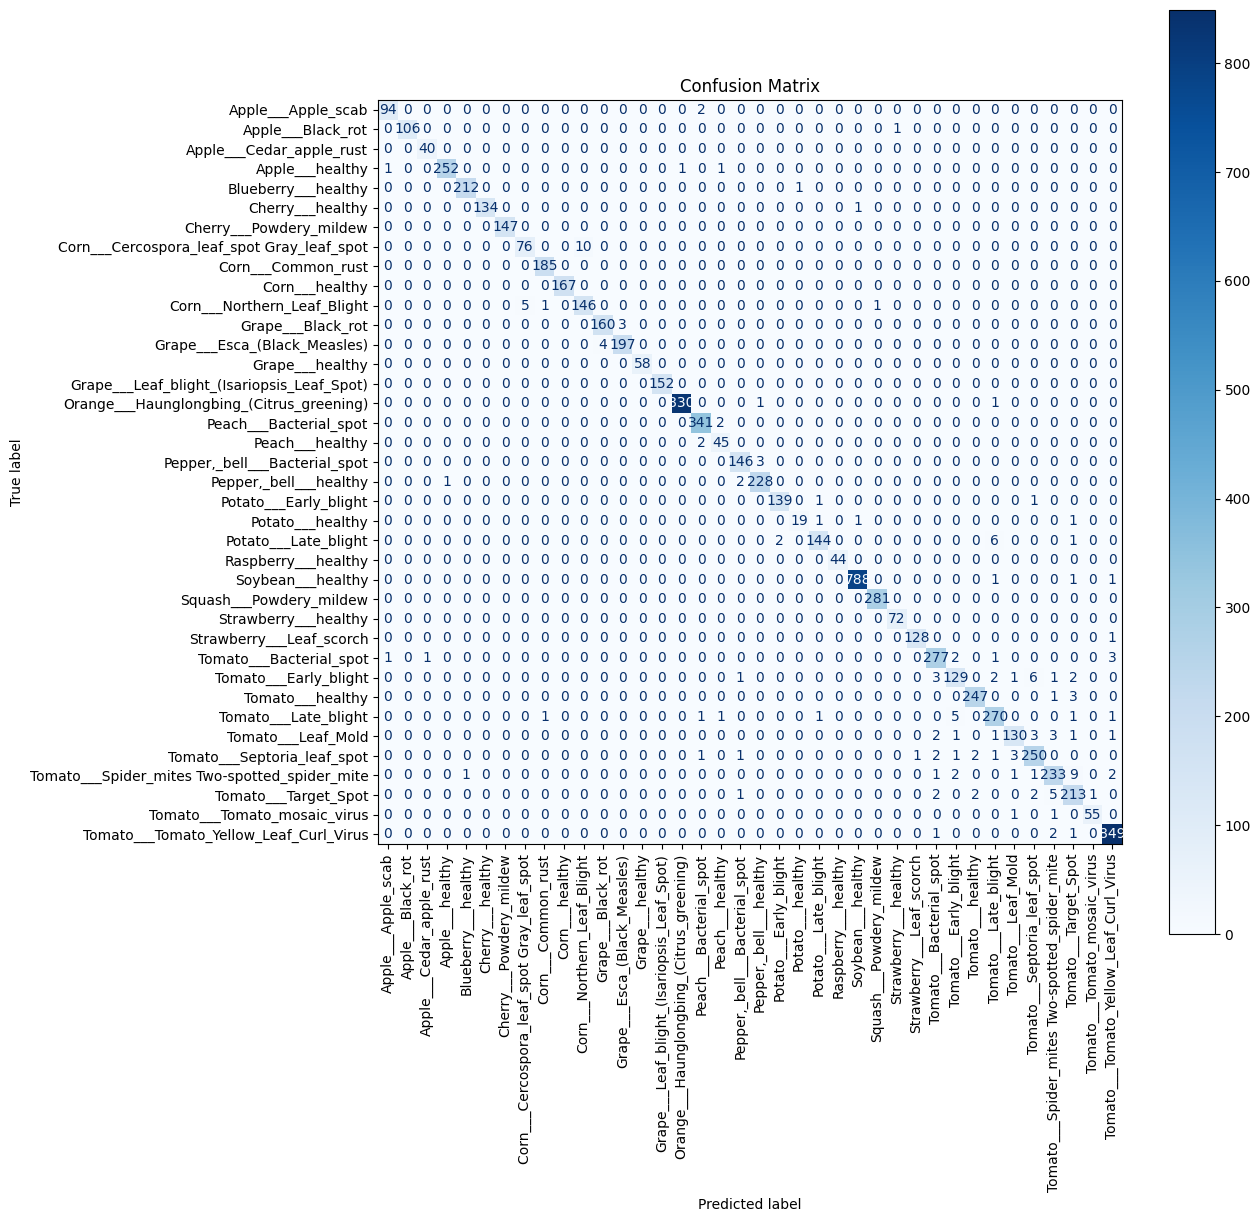

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

# Evaluate
test_loss, test_acc = best_model.evaluate(ds_test)
print(f"✅ Test Accuracy: {test_acc:.2%}")

# Predict on test set
y_true, y_pred = [], []
for images, labels in ds_test:
    preds = best_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [37]:
df_report = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).T
df_report

,precision,recall,f1-score,support
Apple___Apple_scab,0.979167,0.979167,0.979167,96.000000
Apple___Black_rot,1.000000,0.990654,0.995305,107.000000
Apple___Cedar_apple_rust,0.975610,1.000000,0.987654,40.000000
Apple___healthy,0.996047,0.988235,0.992126,255.000000
Blueberry___healthy,0.995305,0.995305,0.995305,213.000000
Cherry___healthy,1.000000,0.992593,0.996283,135.000000
Cherry___Powdery_mildew,1.000000,1.000000,1.000000,147.000000
Corn___Cercospora_leaf_spot Gray_leaf_spot,0.938272,0.883721,0.910180,86.000000
Corn___Common_rust,0.989305,1.000000,0.994624,185.000000
Corn___healthy,1.000000,1.000000,1.000000,167.000000


## 9. Model Export for Deployment (TFLite)
---

Converts the best model to a TensorFlow Lite (.tflite) format:

- This format is optimized for deployment on Android and edge devices.
- The converter also applies post-training quantization to reduce model size and latency.

The result is a compact model suitable for mobile inference with offline capabilities.

In [ ]:
# Save model
# best_model.save('best_model_tuned.keras')

# Load model
best_model = tf.keras.models.load_model(
    'best_model_tuned.keras',
    custom_objects=None,
    compile=True,
    safe_mode=True
)

# Export to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('crop_disease_model.tflite', 'wb') as f:
  f.write(tflite_model)

## 10. Streamlit Inference UI
---

Creates a simple web app using Streamlit:

- Loads the trained Keras model.
- Allows the user to upload an image of a leaf.
- Displays the predicted class and confidence score.

This can be run locally with `streamlit run streamlit_app.py.`

In [ ]:
# Save this as streamlit_app.py and run with `streamlit run streamlit_app.py`
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model("best_model_tuned.keras")
class_names = ds_info.features['label'].names

st.title("🌿 AI Crop Disease Detector")
uploaded_file = st.file_uploader("Upload a crop leaf image", type=["jpg", "png"])

if uploaded_file:
  image = Image.open(uploaded_file).resize((160, 160))
  img_array = np.expand_dims(np.array(image) / 255.0, axis=0)
  prediction = model.predict(img_array)
  pred_class = class_names[np.argmax(prediction)]
  confidence = np.max(prediction) * 100
  st.success(f"Prediction: {pred_class} ({confidence:.2f}%)")

## 11. Conclusion & Future Work
---

- Project impact: offers an offline-capable, AI-driven diagnostic tool for crop diseases with potential to reduce yield losses, promote sustainable farming, and improve smallholder livelihoods.

- Extension ideas:

  - Fine-tune on region-specific diseases and crops.
  - Incorporate active learning to allow users to submit new disease samples.
  - Add local language advisory and treatment suggestions.
  - Deploy fully on-device via Android app or integrate into field extension workflows.

- Research relevance: aligned with global efforts to use deep learning for crop protection—where lightweight models like EfficientNetB0 and MobileViT outperform heavier nets with strong generalizability and mobile suitability

*Juan Esteban Rozo Urbina | Bogota, Colombia* 🇨🇴